# TFM Tutorial Notebook 3: Tabular Foundation Models for Time Series

In this tutorial, we introduce a few cutting-edge foundational tabular models that leverage pretraining and in-context learning to achieve state-of-the-art performance on time-series datasets. These models represent a significant advancement in automated machine learning for structured data.

Please use the following instructions to install AutoGluon if needed

``!python -m pip install --upgrade pip``

``!python -m pip install autogluon``

As AutoGluon has only one dedicated TFM (i.e., [Chronos](https://github.com/amazon-science/chronos-forecasting)) for zero-shot predictions, we will first evaluate the performance Chronos's performance and compare it to other baselines provided by AutoGluon.

Then, we will move to TabPFN(v2), which are not yet included in AutoGluon for timeseries applications. We then implement the models separately, while using the same datasets.

AutoGluon-TimeSeries (AG-TS) provides a robust and easy way to use Chronos through the familiar ``TimeSeriesPredictor`` API.

This tutorial describes how to

1. Use Chronos models in zero-shot mode to make forecasts without any dataset-specific training
2. Fine-tune Chronos models on custom data to improve the accuracy
3. Handle covariates & static features by combining Chronos with a tabular regression model
4. Use TabPFN v2 model in zero-shot mode to make forecasts without any dataset-specific training

## 1. Chronos

Please read the [paper](https://arxiv.org/pdf/2403.07815) for more details about how this TFM works.

## Zero-shot Predictions

For the dataset, we use a subset of the [Australian Electricity Demand Dataset](https://zenodo.org/records/4659727). We first load a dataset as ``TimeseriesDataFrame``.

In [1]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
)
data.head()

C:\Users\zhjiang\AppData\Local\miniconda3\envs\tabfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


target
item_id timestamp                       
T000000 2013-03-10 00:00:00  5207.959961
        2013-03-10 00:30:00  5002.275879
        2013-03-10 01:00:00  4747.569824
        2013-03-10 01:30:00  4544.880859
        2013-03-10 02:00:00  4425.952148

To fit the model, we need to call ``TimeSeriesPredictors and select`` and select ``"bolt_small"`` presets to use the Chronos-Bolt (Small, 48M) model in zero-shot mode.

In [2]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to 'C:\Users\zhjiang\Documents\tabfm_tutorial\AutogluonModels\ag-20251024_170016'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       2.11 GB / 15.93 GB (13.3%)
Disk Space Avail:   230.55 GB / 476.33 GB (48.4%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Infe

The ``fit()`` call merely serves as a proxy for the ``TimeSeriesPredictor`` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk. We also use ``predict`` method to generate forecasts, and the ``plot`` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


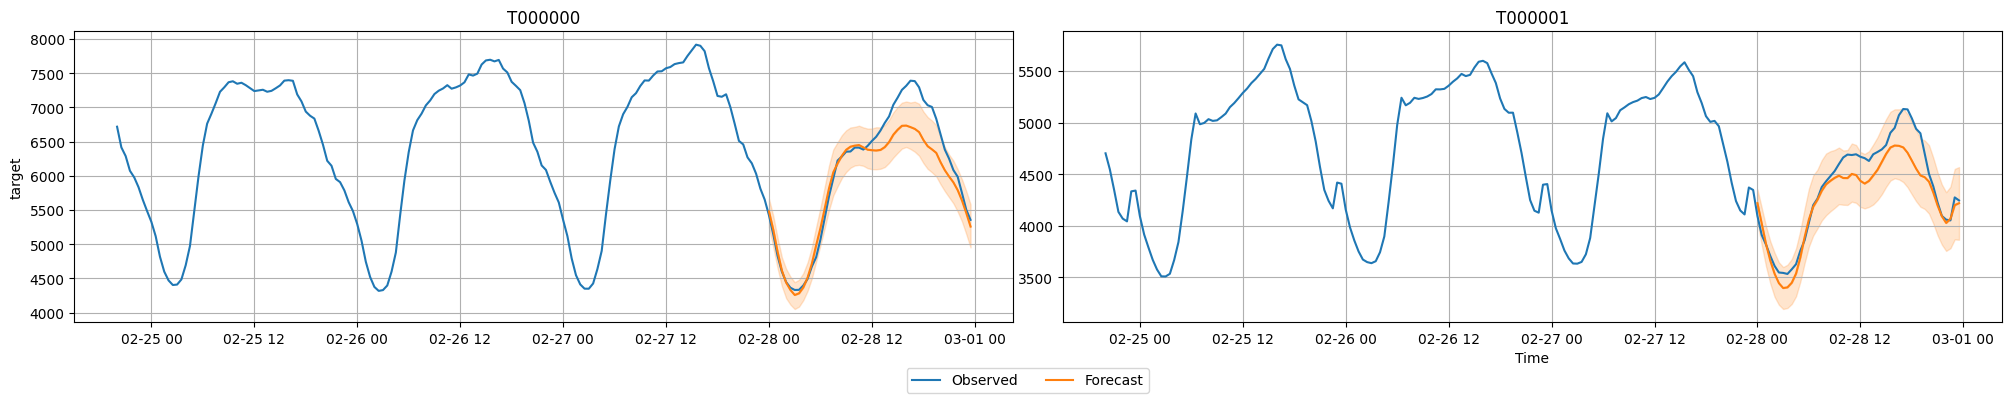

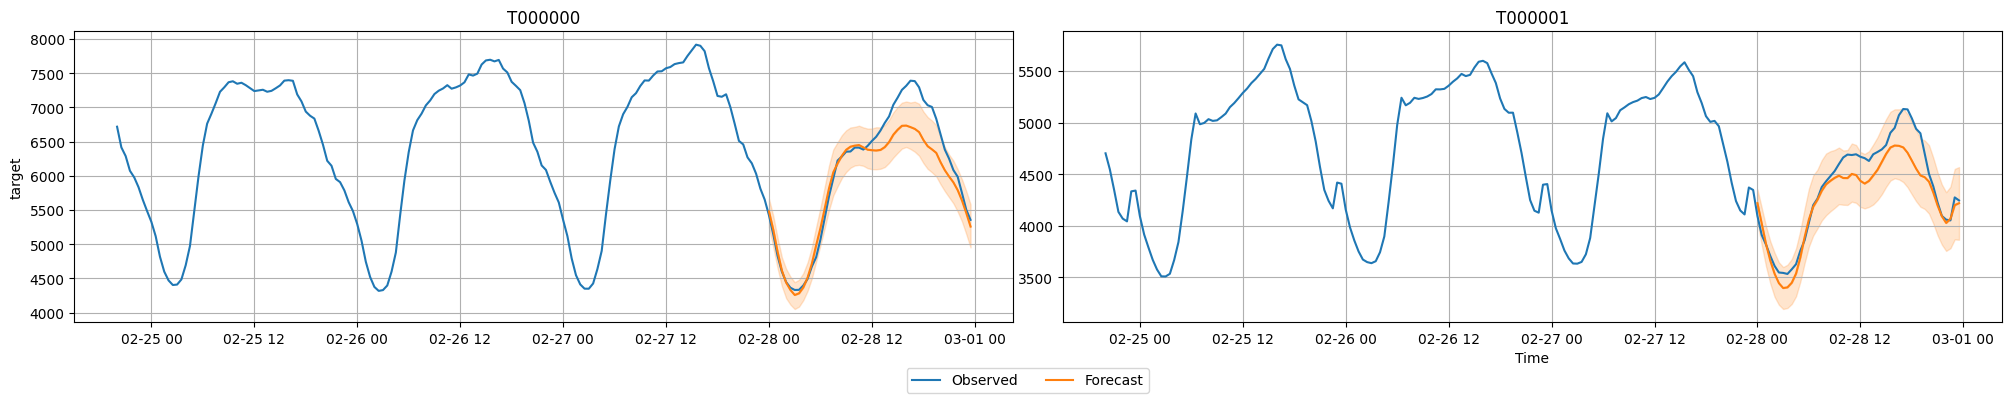

In [3]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
)

## Fine-tuning Chronos

We have seen above how Chronos models can produce forecasts in zero-shot mode. AutoGluon also makes it easy to fine-tune Chronos models on a specific dataset to maximize the predictive accuracy.

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}}, # Zero-shot mode.
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ],
        # We also add a couple baselines for comparison.
        "DeepAR": {},
        "Theta": {},
        "TemporalFusionTransformer": {},
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

In [ ]:
predictor.leaderboard(test_data)

## Incorporating Covariates

Chronos is a univariate model, meaning it relies solely on the historical data of the target time series for making predictions. Therefore, Chronos cannot be directly used for regression with multiple inputs for now. However, in real-world scenarios, additional exogenous information related to the target series (e.g., holidays, promotions) is often available. Leveraging this information when making predictions can improve forecast accuracy.

AG-TS now features covariate regressors that can be combined with univariate models like Chronos-Bolt to incorporate exogenous information. A ``covariate_regressor`` in AG-TS is a tabular regression model that is fit on the known covariates and static features to predict the target column at the each time step. The predictions of the covariate regressor are subtracted from the target column, and the univariate model then forecasts the residuals.

However, in the recently released **Chronos-2**, the developers have address this to make the covariates naturally built-in the model, instead of using another covariate regressor. However, we will not cover implmentation for Chronos-2 in this tutorial and encourage people to run its [tutoriral notebook](https://github.com/amazon-science/chronos-forecasting/blob/main/notebooks/chronos-2-quickstart.ipynb).

Next, we use three datasets to illustrate how covariates impact the output.

1. Grocery sales data, which is a built-in data in AutoGluon.
2. [Wind energy data](http://apmonitor.com/pds/uploads/Main/wind.txt), which is an publicly available time-series data in renewable energy domain
3. [SECOM data](https://archive.ics.uci.edu/dataset/179/secom), which is a manufacturing process feature selection and categorization

The first two are for regression while the last one is classification.

## Grocery Sales Data

In [4]:
grocery_data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/grocery_sales/test.csv",
)
grocery_data.head()

scaled_price  promotion_email  promotion_homepage  \
item_id  timestamp                                                       
1062_101 2018-01-01      0.879130              0.0                 0.0   
         2018-01-08      0.994517              0.0                 0.0   
         2018-01-15      1.005513              0.0                 0.0   
         2018-01-22      1.000000              0.0                 0.0   
         2018-01-29      0.883309              0.0                 0.0   

                     unit_sales  
item_id  timestamp               
1062_101 2018-01-01       636.0  
         2018-01-08       123.0  
         2018-01-15       391.0  
         2018-01-22       339.0  
         2018-01-29       661.0

## Wind Energy Data

In [9]:
import pandas as pd
url = 'http://apmonitor.com/pds/uploads/Main/wind.txt'
wind_df = pd.read_csv(url)

# Drop faulty zero-power rows.
wind_df = wind_df[wind_df['Power'] > 0].reset_index(drop=True)
wind_df["item_id"] = 1
wind_df = wind_df.rename(columns={"Time": "timestamp"})
wind_df = wind_df[["item_id", "timestamp", "Direction", "Speed", "Power"]][:10000] # We only select the first 10000 samples.
nan_counts_per_column = wind_df.isna().sum()
print("Number of NaN values in each column:")
print(nan_counts_per_column)
wind_data = TimeSeriesDataFrame(wind_df) # Please remember to convert the data into a TimeSeriesDataFrame structure.
wind_data.head()

Number of NaN values in each column:
item_id      0
timestamp    0
Direction    0
Speed        0
Power        0
dtype: int64


Direction     Speed       Power
item_id timestamp                                            
1       2018-01-01 00:00:00  259.994904  5.311336  380.047791
        2018-01-01 00:10:00  268.641113  5.672167  453.769196
        2018-01-01 00:20:00  272.564789  5.216037  306.376587
        2018-01-01 00:30:00  271.258087  5.659674  419.645904
        2018-01-01 00:40:00  265.674286  5.577941  380.650696

## Manufacturing Data

In [11]:
import requests
from io import BytesIO

train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
labels_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'

# Download and read the main data.
response_data = requests.get(train_url)
data = pd.read_csv(BytesIO(response_data.content), sep=' ', header=None)

# Download and read the labels data.
response_labels = requests.get(labels_url)
labels_data = pd.read_csv(BytesIO(response_labels.content), sep=' ', header=None)

semi_df = pd.merge(data, labels_data, left_index=True, right_index=True, how='inner')

semi_df = semi_df.rename(columns={'0_y': "target", '1_y': 'timestamp'})
semi_df = semi_df[["0_x", "1_x", "target", "timestamp"]] # We only select the first two features for demo.
semi_df["item_id"] = 1
semi_data = TimeSeriesDataFrame(semi_df)
semi_data.head()

C:\Users\zhjiang\AppData\Local\miniconda3\envs\tabfm\Lib\site-packages\autogluon\timeseries\dataset\ts_dataframe.py:191: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[TIMESTAMP] = pd.to_datetime(df[TIMESTAMP])


0_x      1_x  target
item_id timestamp                                    
1       2008-07-19 11:55:00  3030.93  2564.00      -1
        2008-07-19 12:32:00  3095.78  2465.14      -1
        2008-07-19 13:17:00  2932.61  2559.94       1
        2008-07-19 14:43:00  2988.72  2479.90      -1
        2008-07-19 15:22:00  3032.24  2502.87      -1

In [14]:
prediction_length = 16
train_data, test_data = wind_data.train_test_split(prediction_length=prediction_length)

For comparison, we define two Chronos models.

1. Zero-shot configuration that uses only the historical values of the target without considering the covariates
2. A configuration with a CatBoost regression model as the ``covariate_regressor``. Note that we recommend to apply a ``target_scaler`` when using a covariate regressor. Target scaler ensures that all time series have comparable scales, often leading to better accuracy.

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq='10min', # If frequency is irregular, then this is typically required.
    target="Power", # or "unit_sales" or "target"
    # known_covariates_names=["scaled_price", "promotion_email", "promotion_homepage"],
    known_covariates_names=["Direction", "Speed"],
    # known_covariates_names=["0_x", "1_x"],
).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
        # We also include a few baselines for comparison.
        "DeepAR": {},
        "ETS": {},
        "Theta": {},
        "TemporalFusionTransformer": {},
    },
    enable_ensemble=False,
    # time_limit=60,
)

In [ ]:
predictor.leaderboard(test_data)

**Important Note: Note that the covariates may not always be useful — for some datasets, the zero-shot model may achieve better accuracy. Therefore, it’s always important to try out multiple models and select the one that achieves the best accuracy on held-out data.**

Please also try out other datasets.

## 2. TabPFNv2

In AutoGluon, TabPFN has not been integrated for timeseries data. Hence, we will implement TabPFN(v2) separately with a couple real datasets. The Prior Labs team has recently developed a variant dedicated to timeseries data, called [tabpfn-time-series](https://github.com/PriorLabs/tabpfn-time-series). We will also implement this. This variant also requires an API client for further processing.

In the next, we will start with a vanilla TabPFN(v2) for timeseries data (wind energy).

We first install tabpfn as follows if you haven't done this:

``!pip install tabpfn``

GPU Recommended: For optimal performance, use a GPU (even older ones with ~8GB VRAM work well; 16GB needed for some large datasets). On CPU, only small datasets (≲1000 samples) are feasible. No GPU? You can use their free hosted inference via TabPFN Client.

In [15]:
import matplotlib.pyplot as plt
import torch
import xgboost as xgb
from tabpfn import TabPFNRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

In [ ]:
# # Horizon.
training_length = 5000
testing_length = 500
horizon = 1

# Please make sure that the output for the power is single step, as multiple steps are not yet supported.
# We obtain the training and testing data.
X_train = wind_data[['Speed', 'Direction']][:training_length]
y_train = wind_data['Power'][horizon:training_length+horizon]
X_test = wind_data[['Speed', 'Direction']][training_length:training_length+testing_length]
y_test = wind_data['Power'][training_length+horizon:training_length+testing_length+horizon]

# 2. Train TabPFN Regressor on full dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TabPFNRegressor(
    device=device,
    ignore_pretraining_limits=True  # allow >10k rows
)
model.fit(X_train.values, y_train.values)

# 3. Direct prediction with TabPFN
y_pred_tabpfn = model.predict(X_test.values)

# 4. Train an XGBoost model
regr = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
regr.fit(X_train.values, y_train.values)
y_pred_xgboost = regr.predict(X_test.values)

# 4. Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="tab:blue")
plt.plot(y_pred_tabpfn,
         label="Predicted TabPFN", color="tab:orange", linestyle="--")
plt.plot(y_pred_xgboost,
         label="Predicted XGBoost", color="tab:green", linestyle="--")

plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Wind Power (kW)", fontsize=14)
plt.legend(fontsize=12)
plt.title("TabPFN Direct Prediction of Wind Power", fontsize=16)
plt.tight_layout()
plt.show()

# 5. Output evaluation metrics.
mse_tabpfn = root_mean_squared_error(y_test.values, y_pred_tabpfn)
mse_xgboost = root_mean_squared_error(y_test.values, y_pred_xgboost)
r2_tabpfn = r2_score(y_test.values, y_pred_tabpfn)
r2_xgboost = r2_score(y_test.values, y_pred_xgboost)

print("Root Mean Squared Error (MSE) for TabPFN:", mse_tabpfn)
print("Root Mean Squared Error (MSE) for XGBoost:", mse_xgboost)
print("R² Score for TabPFN:", r2_tabpfn)
print("R² Score for XGBoost:", r2_xgboost)

**Note: when using the manufacturing data for testing TabPFN, we need to use TabPFNClassifier due to the binary class in the target column. Also, the class should be ``{0,1}``, isntead of ``{-1,1}``. Essentially, this is a timeseries classification problem, instead of regression problem.**

## Time-series Variant of TabPFN(v2)

We next investigate the tabpfn-time-series, which is dedicated to timeseries data but still being developed. Please check [the paper](https://arxiv.org/pdf/2501.02945) and its [GitHub Repo](https://github.com/PriorLabs/tabpfn-time-series?tab=readme-ov-file) for more details.

You also need to install its specific version as follows:

``!uv pip install tabpfn-time-series>=1.0.3``

if you haven't done so. To demonstrate how it works, we use the Monash Tourism Data.

In [ ]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [ ]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

In [ ]:
from datasets import load_dataset
from tabpfn_time_series import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

prediction_length = dataset_metadata[dataset_choice]["prediction_length"]
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset["train"]))
tsdf = tsdf[
    tsdf.index.get_level_values("item_id").isin(tsdf.item_ids[:num_time_series_subset])
]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(
    prediction_length=prediction_length
)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

We can observe that the construction of TimeSeriesDataFrame is somewhat similar to that in AutoGluon.

In [ ]:
# Visulize the data
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

In [ ]:
# Transform the some time features into temporal embeddings.
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)

train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)

In [ ]:
train_tsdf.head()

In [ ]:
test_tsdf.head()

We next call the predictor. However, if you don't have enough compute, TabPFN-TS has provided an API client for you. That way, you can use TabPFN's inference service instead of running TabPFN on your local machine. This could be much faster. If you have not used the client before, you will be prompted to create an account. Whenever you use again, you need to provide your account and password.

In [ ]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.CLIENT,
)

pred = predictor.predict(train_tsdf, test_tsdf)

In [ ]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)